In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Step1. Data Exploration 
load data and check categorical and numerical data

In [60]:
df = pd.read_csv('/home/ren/Loan/loan.csv', header=0) 

In [36]:
len(df.columns)
#df = pd.read_csv('/home/ren/Loan/loan.csv', header=0) 
#df.to_csv('/home/ren/Loan/dff.csv',sep=';')

74

In [4]:
pd.DataFrame(list(df.loan_status.value_counts().items()),columns=['Status','Total'])
#take a look at the target
#from collections import Counter
#c=Counter(list(df.loan_status))
#c.most_common()

,Status,Total
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,In Grace Period,6253
6,Late (16-30 days),2357
7,Does not meet the credit policy. Status:Fully ...,1988
8,Default,1219
9,Does not meet the credit policy. Status:Charge...,761


In [61]:
#We will fist look at loans that are not Current, either default or fully paid
df=df[df.loan_status!='Current']

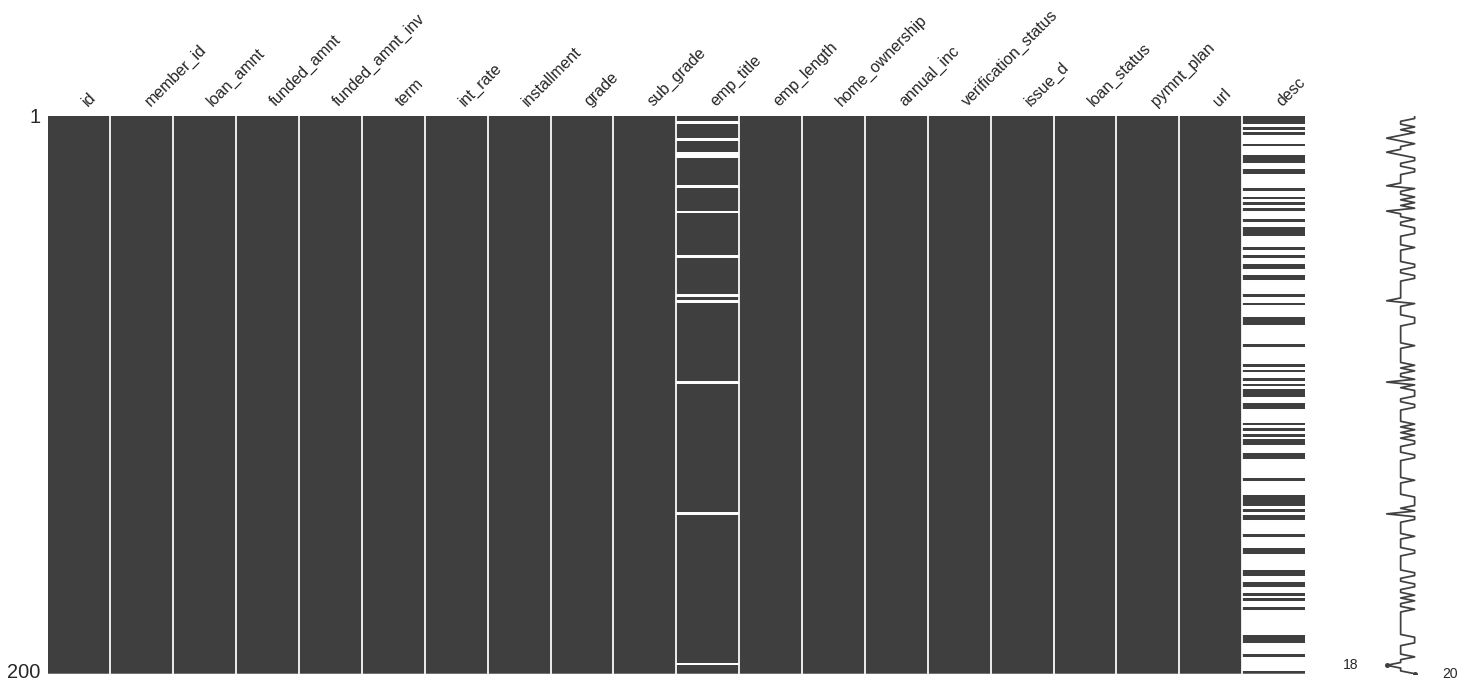

In [53]:
#map of missing values
import missingno as msno
msno.matrix(df.iloc[:,:20].sample(200))

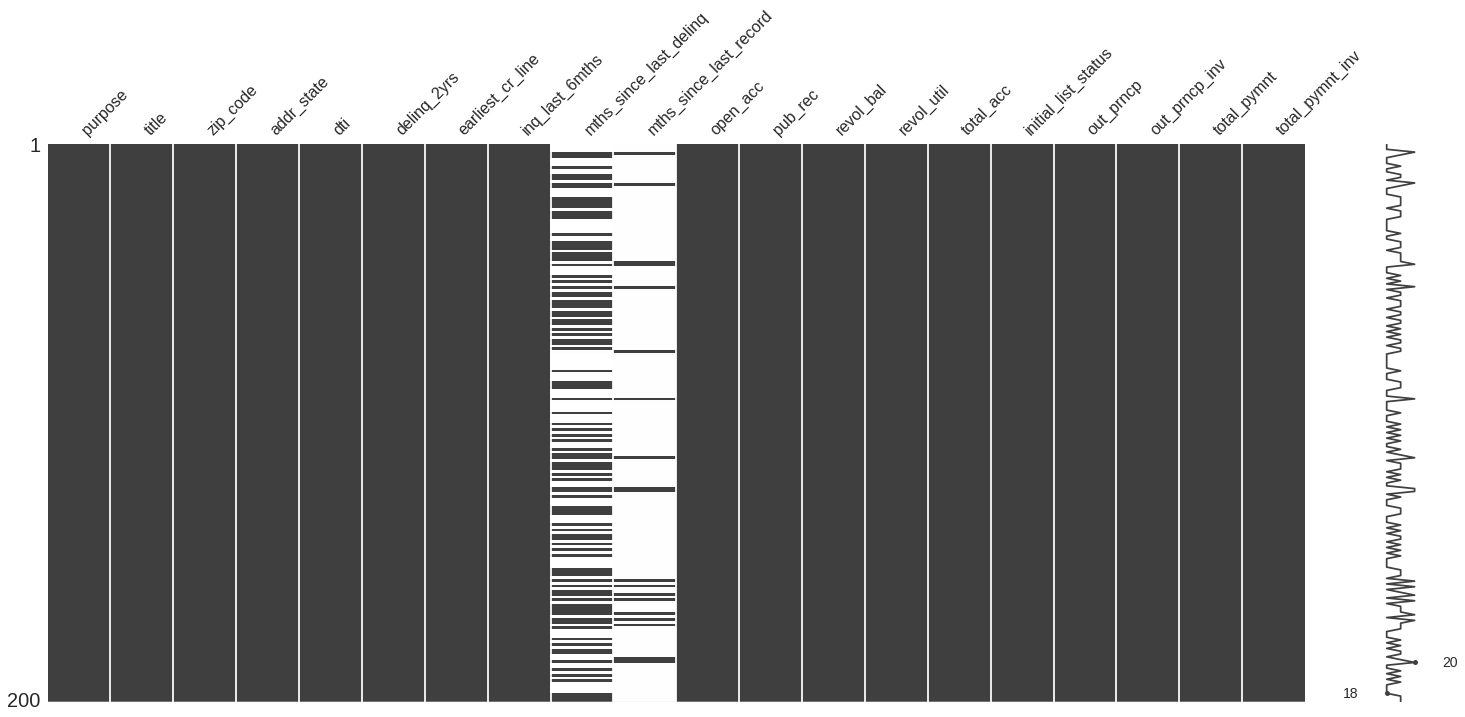

In [16]:
msno.matrix(df.iloc[:,20:40].sample(200))

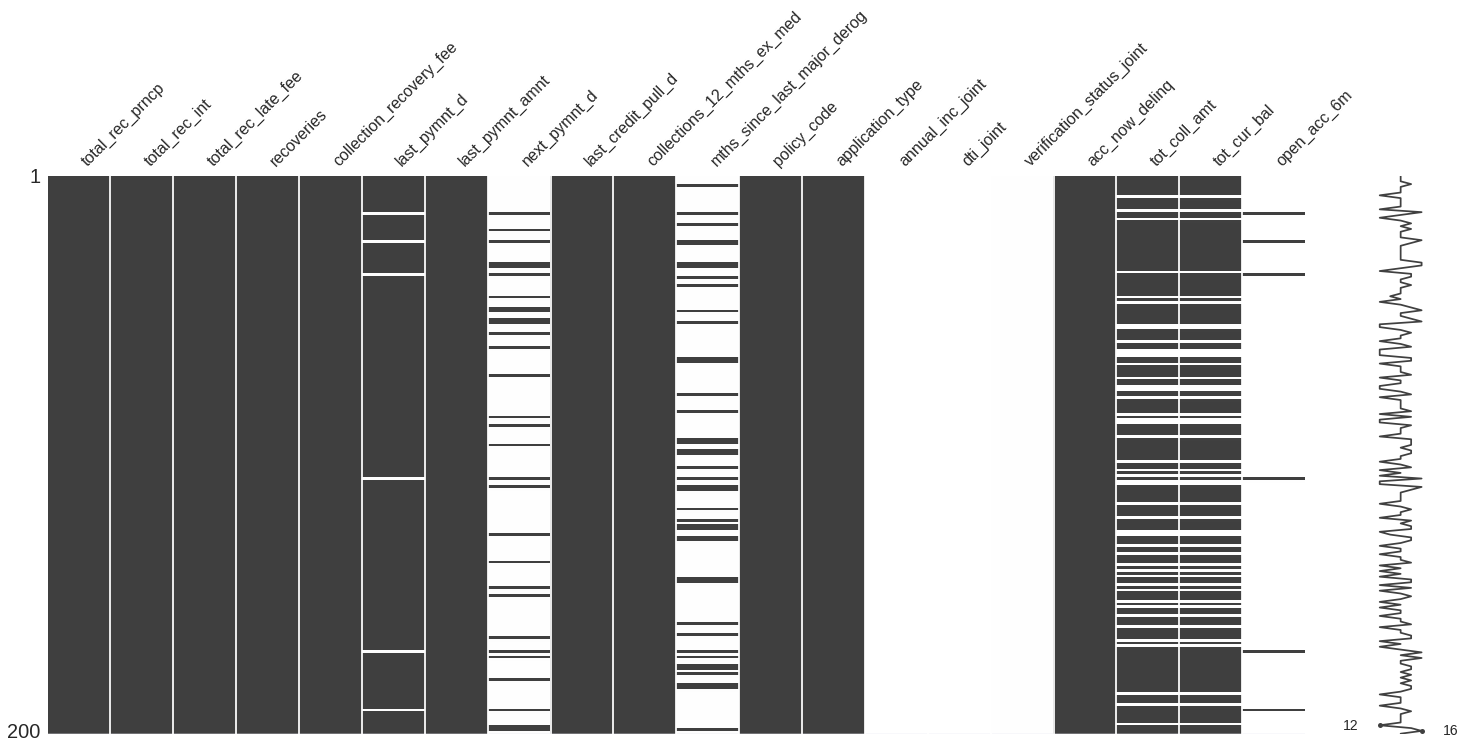

In [17]:
msno.matrix(df.iloc[:,40:60].sample(200))

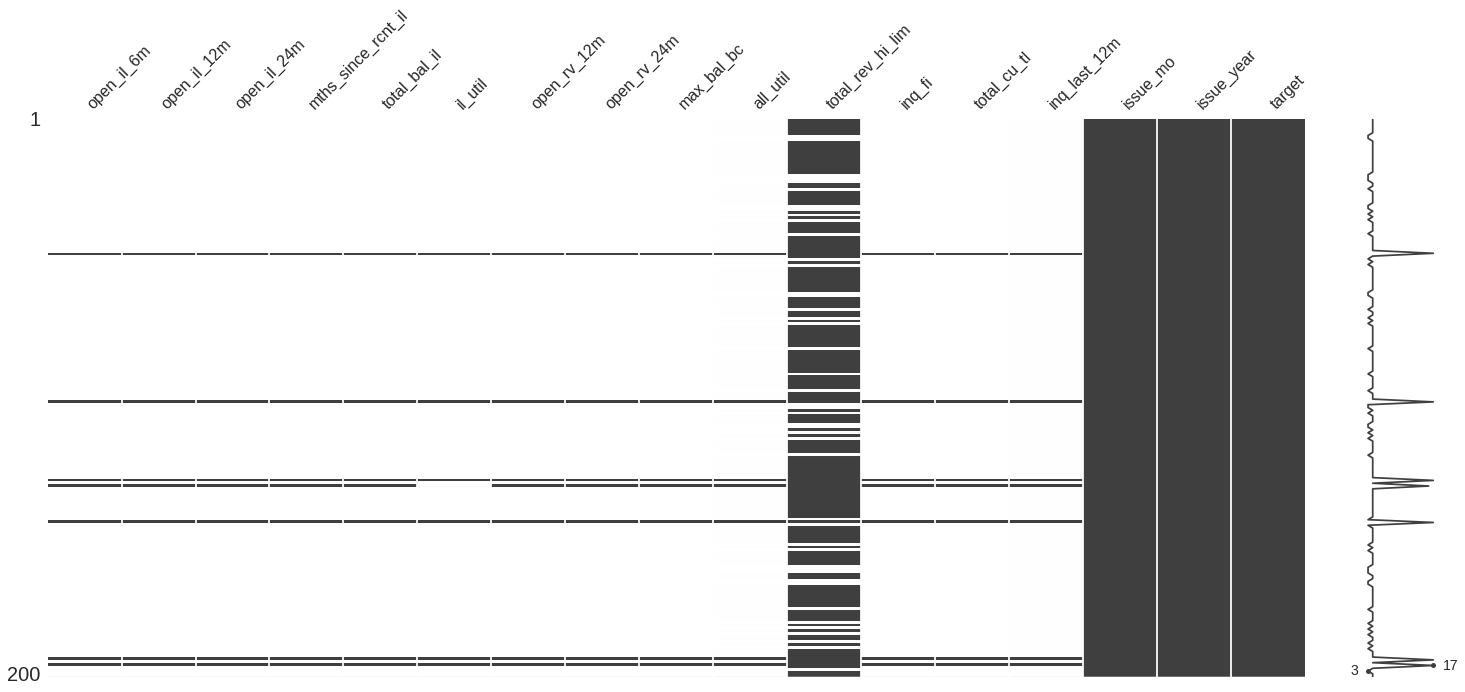

In [54]:
msno.matrix(df.iloc[:,60:80].sample(200))

# Divide and Conquer 
seperate categorical and numerical data

First, let's look at the target value. Defaulted loans or loans that are late are maked as 1.

In [6]:
pd.DataFrame(list(df.loan_status.value_counts().items()),columns=['Feature','Total'])

,Feature,Total
0,Fully Paid,207723
1,Charged Off,45248
2,Late (31-120 days),11591
3,Issued,8460
4,In Grace Period,6253
5,Late (16-30 days),2357
6,Does not meet the credit policy. Status:Fully ...,1988
7,Default,1219
8,Does not meet the credit policy. Status:Charge...,761


In [62]:
#let's map the loan status to target value
from collections import Counter
c=Counter(list(df.loan_status))
mmp={x[0]:1 for x in c.most_common(20)}
mmp['Fully Paid']=0
mmp['Does not meet the credit policy. Status:Fully Paid']=0
mmp['Issued']=0
df['target']=df['loan_status'].map(mmp)

In [63]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nCol = df.select_dtypes(include=numerics).columns
oCol=[x for x in df.columns if x not in nCol]
print("Total number of columns: ", len(df.columns))
print("Total number of numerical columns: ", len(nCol))
print("Total number of categorical columns: ", len(oCol))

Total number of columns:  75
Total number of numerical columns:  52
Total number of categorical columns:  23


In [64]:
dCol=[x for x in oCol if x.endswith('d')]
dCol=dCol+['earliest_cr_line']
oCol=[x for x in oCol if x not in dCol]
print("Total number of categorical columns: ", len(oCol))
print("Total number of date columns: ", len(dCol))


Total number of categorical columns:  18
Total number of date columns:  5


In [7]:
null_oCol=dict()
for i in oCol:
    if sum(df[i].isnull())<10000:
        null_oCol[i]=sum(df[i].isnull())
pd.DataFrame(list(null_oCol.items()),columns=['Feature','Null number'])

,Feature,Null number
0,url,0
1,verification_status,0
2,purpose,0
3,pymnt_plan,0
4,application_type,0
5,title,151
6,sub_grade,0
7,home_ownership,0
8,addr_state,0
9,emp_length,0


# Date features

In [11]:
null_dCol=dict()
for i in dCol:
    null_dCol[i]=sum(df[i].isnull())
pd.DataFrame(list(null_dCol.items()),columns=['Feature','Null number'])

,Feature,Null number
0,last_pymnt_d,9333
1,last_credit_pull_d,24
2,issue_d,0
3,next_pymnt_d,252971
4,earliest_cr_line,29


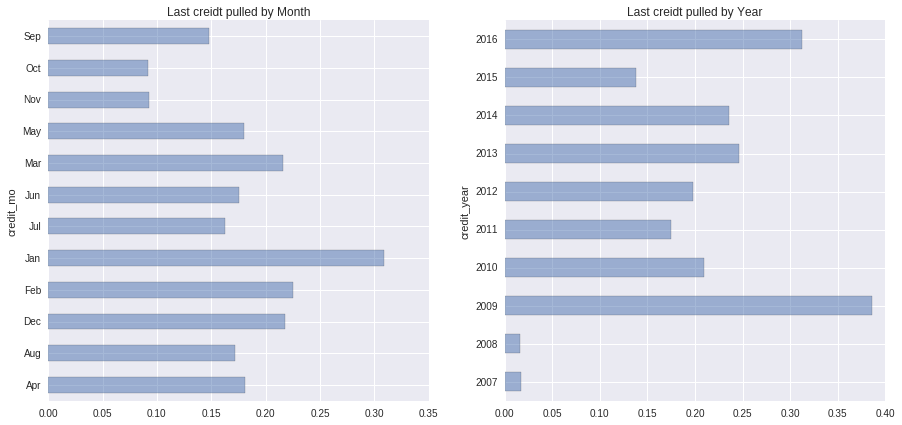

In [93]:

df['credit_mo'] = df.last_credit_pull_d.str[0:3]
df['credit_year'] = df.last_credit_pull_d.str[4:]
#loan_by_month = loan.groupby(['issue_year','issue_mo'])
#credit_by_year = df.groupby(['credit_year'])

plt.subplot(2,2,1)
#pd.pivot_table(df, values='target', index='issue_mo').plot(kind='barh',alpha=0.5, figsize=(15, 15),title = 'Loans by Month')
df.groupby('credit_mo')['target'].agg(np.mean).plot(kind='barh',alpha=0.5, figsize=(15, 15), title = 'Last creidt pulled by Month')
plt.subplot(2,2,2)
df.groupby('credit_year')['target'].agg(np.mean).plot(kind='barh',alpha=0.5, figsize=(15, 15), title = 'Last creidt pulled by Year')
#

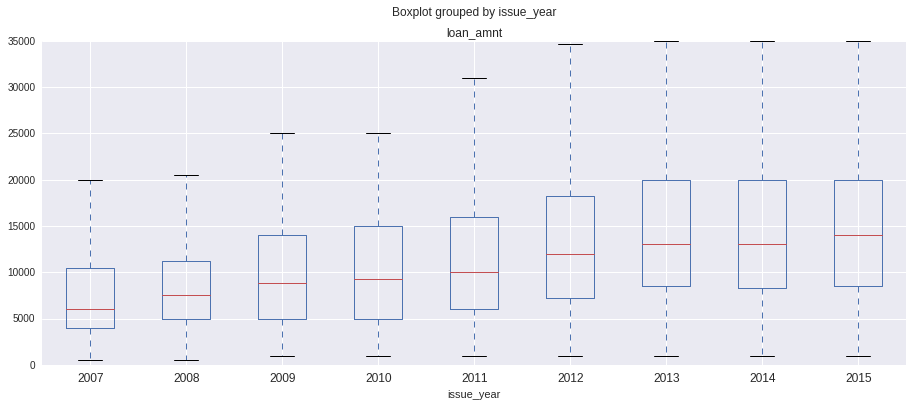

In [21]:
df['issue_mo'] = df.issue_d.str[0:3]
df['issue_year'] = df.issue_d.str[4:]
#loan_by_month = loan.groupby(['issue_year','issue_mo'])
loan_by_month = df.groupby(['issue_year'])
df.boxplot(column='loan_amnt', by='issue_year',figsize=(15, 6))
#avgLoanSizeByMonth = loan_by_month['funded_amnt_inv'].agg(np.mean).plot(kind='bar',alpha=0.5, figsize=(10, 6))

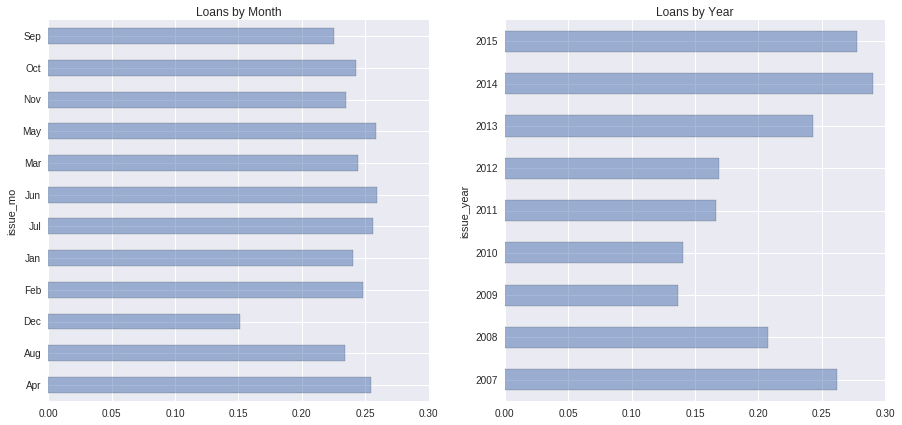

In [78]:
plt.subplot(2,2,1)
#pd.pivot_table(df, values='target', index='issue_mo').plot(kind='barh',alpha=0.5, figsize=(15, 15),title = 'Loans by Month')
df.groupby('issue_mo')['target'].agg(np.mean).plot(kind='barh',alpha=0.5, figsize=(15, 15), title = 'Loans by Month')
plt.subplot(2,2,2)
df.groupby('issue_year')['target'].agg(np.mean).plot(kind='barh',alpha=0.5, figsize=(15, 15), title = 'Loans by Year')
#pd.pivot_table(df, values='target', index='issue_year').plot(kind='barh',alpha=0.5, figsize=(15, 15), title = 'Loans by Year')

Date features to use: last_credit_pull_d, issue_d

# Location features

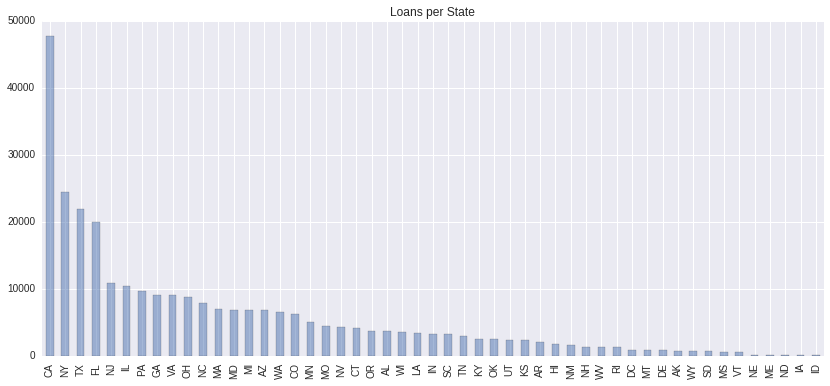

In [31]:
state_count = df.addr_state.value_counts()
state_count.plot(kind = 'bar', alpha=0.5, figsize=(14,6), title = 'Loans per State')

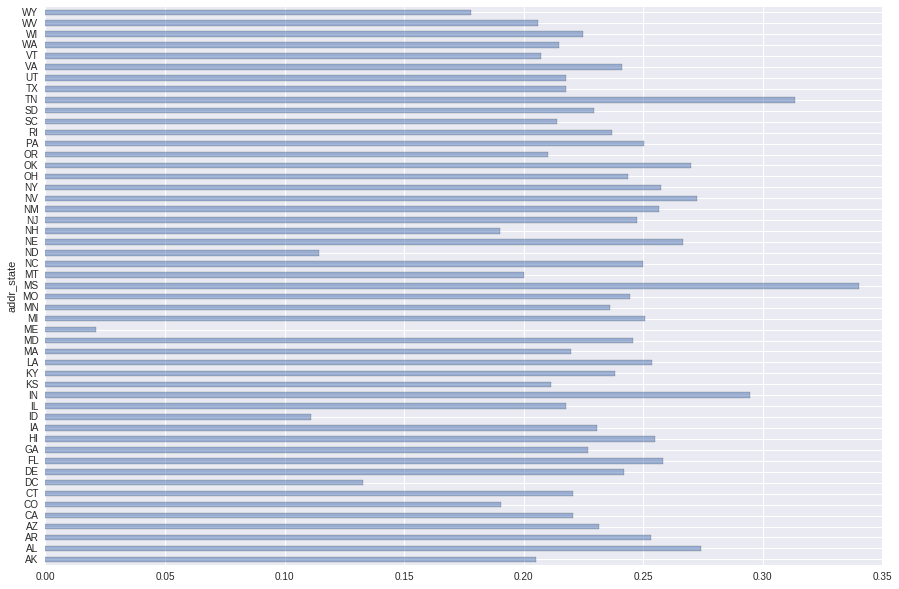

In [128]:
pd.pivot_table(df, values='target', index="addr_state").plot(kind='barh',alpha=0.5, figsize=(15, 10))

# Take a look at the rest of the categories

In [12]:
n=[k for k, v in null_oCol.items() if v > 10000]
cl=[x for x in oCol if x not in n]
print(cl)
cl2=list( cl[i] for i in [0,1,2,4,5,6,8,11,15,16,17] )
print()
print(cl2)


['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'application_type', 'verification_status_joint']

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'verification_status_joint']


In [ ]:
for i in cl2:
    c=Counter(list(df[i]))
    print(i)
    print(list(c.most_common(10)))
    print()

term
[(' 36 months', 621125), (' 60 months', 266254)]

grade
[('B', 254535), ('C', 245860), ('A', 148202), ('D', 139542), ('E', 70705), ('F', 23046), ('G', 5489)]

sub_grade
[('B3', 56323), ('B4', 55626), ('C1', 53387), ('C2', 52236), ('C3', 50161), ('C4', 48857), ('B5', 48833), ('B2', 48781), ('B1', 44972), ('A5', 44816)]

emp_length
[('10+ years', 291569), ('2 years', 78870), ('< 1 year', 70605), ('3 years', 70026), ('1 year', 57095), ('5 years', 55704), ('4 years', 52529), ('n/a', 44825), ('7 years', 44594), ('8 years', 43955)]

home_ownership
[('MORTGAGE', 443557), ('RENT', 356117), ('OWN', 87470), ('OTHER', 182), ('NONE', 50), ('ANY', 3)]

verification_status
[('Source Verified', 329558), ('Verified', 291071), ('Not Verified', 266750)]

pymnt_plan
[('n', 887369), ('y', 10)]

purpose
[('debt_consolidation', 524215), ('credit_card', 206182), ('home_improvement', 51829), ('other', 42894), ('major_purchase', 17277), ('small_business', 10377), ('car', 8863), ('medical', 8540), ('moving

In [9]:
cl2=['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose']

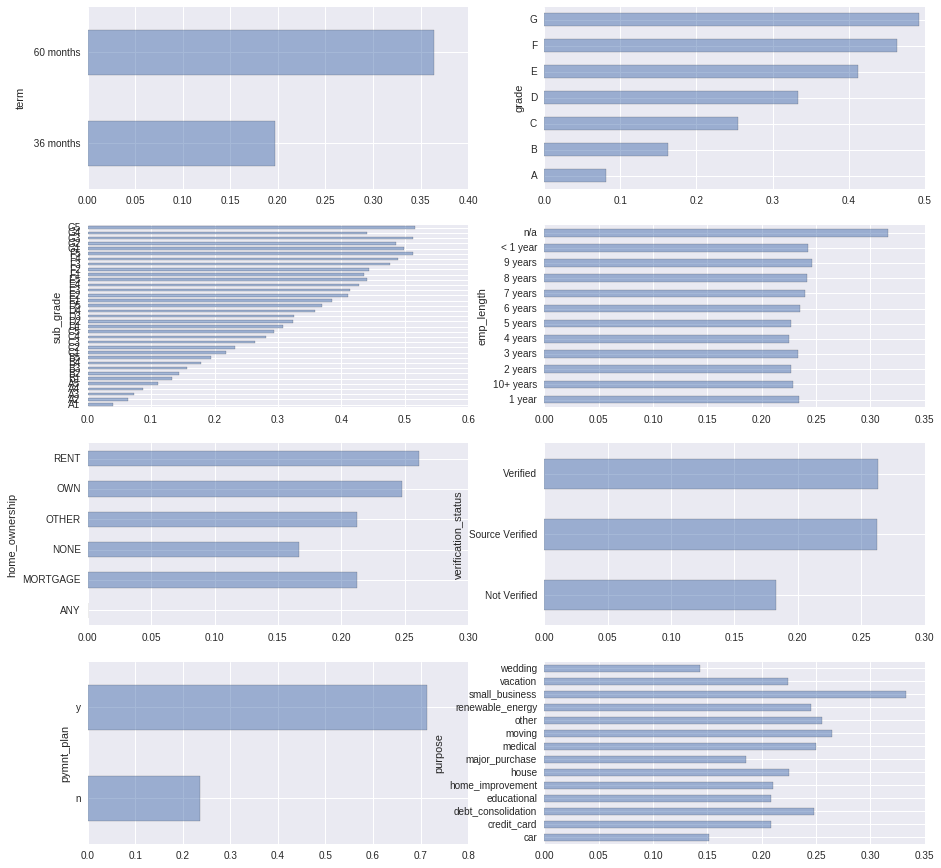

In [16]:
n=1
for i in cl2:
    plt.subplot(4,2,n)
    pd.pivot_table(df, values='target', index=i).plot(kind='barh',alpha=0.5, figsize=(15, 15), title=i)
    n+=1

We can already see strong relations between some features: grade, sub_grade, term, purpose.
Columns to use: term, sub_grade, purpose, home_ownership

In [17]:
#Pyment_plan looks good on graph, but actually it's very imbalanced, so not very useful
c=Counter(df.pymnt_plan)
c.most_common()

[('n', 285593), ('y', 7)]

# Numerical features

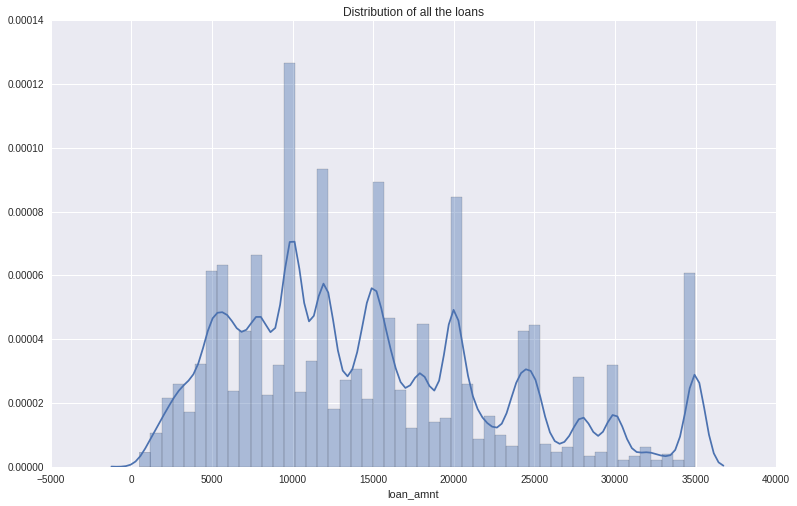

In [8]:
plt.figure(figsize=(13, 8))
plt.title('Distribution of all the loans')
sns.distplot(df.loan_amnt)

In [12]:
null_nCol=dict()
for i in nCol:
    if sum(df[i].isnull()) < 10000:
        null_nCol[i]=sum(df[i].isnull())
pd.DataFrame(list(null_nCol.items()),columns=['Feature','Null number'])

,Feature,Null number
0,funded_amnt_inv,0
1,revol_util,502
2,open_acc,29
3,int_rate,0
4,target,0
5,inq_last_6mths,29
6,pub_rec,29
7,installment,0
8,recoveries,0
9,total_pymnt_inv,0


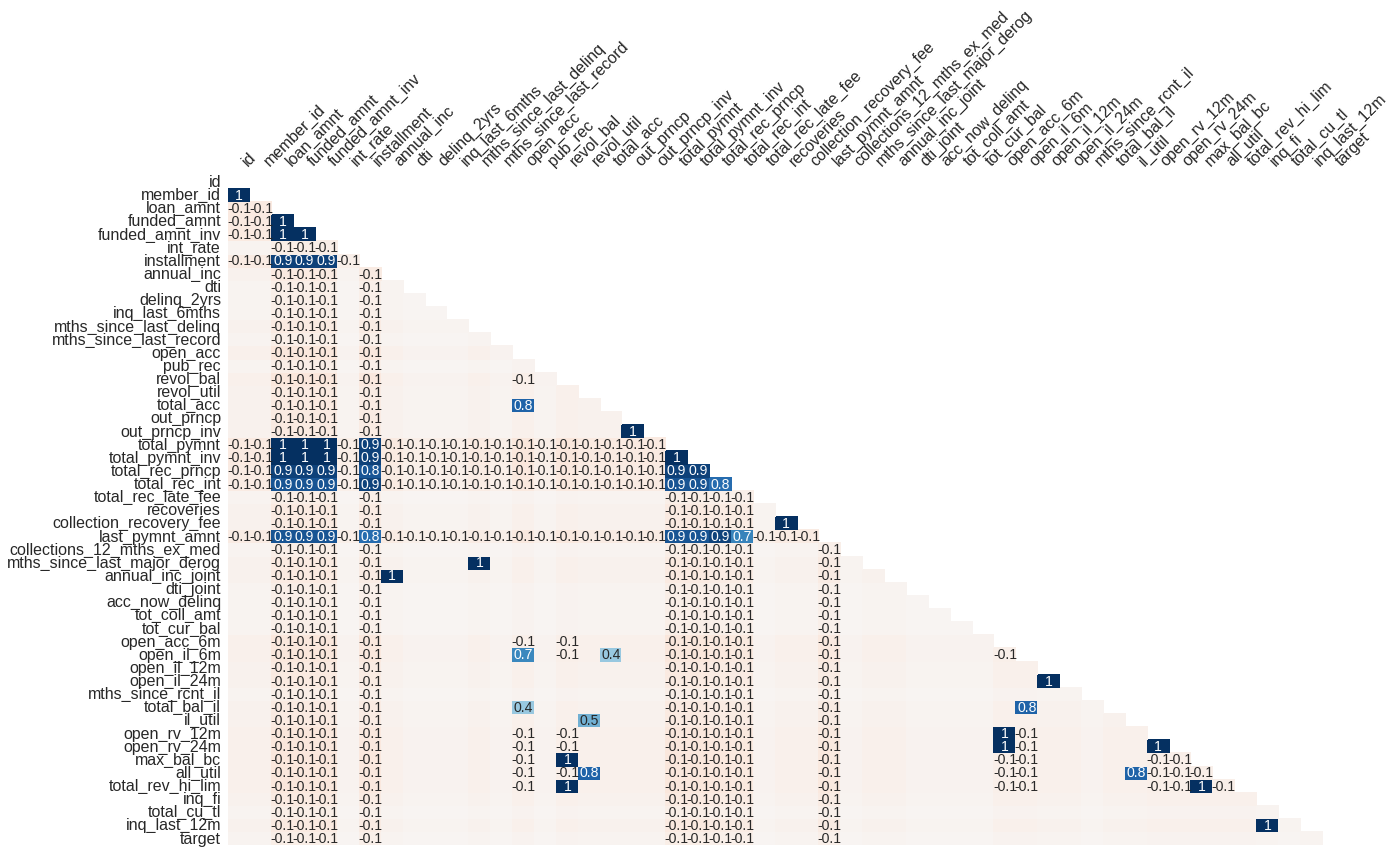

In [19]:
msno.heatmap(corM[corM>0.5])

In [18]:
#check correlation 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
ndf = df.select_dtypes(include=numerics)
corM=ndf.corr(method='pearson', min_periods=1)
corM[corM>0.5]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,target
id,1.000000,0.999099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.999099,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,NaN,NaN,1.000000,0.997821,0.990971,NaN,0.954193,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt,NaN,NaN,0.997821,1.000000,0.993653,NaN,0.957432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt_inv,NaN,NaN,0.990971,0.993653,1.000000,NaN,0.950485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,NaN,NaN,0.954193,0.957432,0.950485,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delinq_2yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most funded amount or payment are highly correlated, we will use loan_amnt 

In [65]:
#clean the cata, eliminate null value and outliers
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
    
def missingToMean(data):
    return data.fillna(np.mean(data))    

In [66]:
n=[k for k, v in null_nCol.items() if v > 1000]
cn=[x for x in nCol if x not in n]
cn2=list( cn[i] for i in [2,5,7,8,15,16,17] )


# Distribution of the features relative to the target value

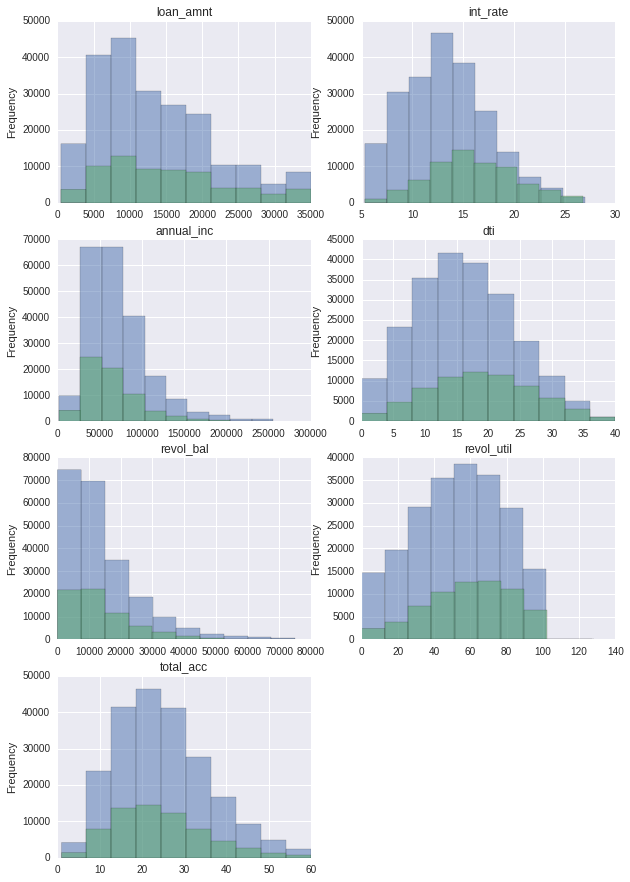

In [22]:
plt.figure()
n=1
for i in cn2:
    df[i]=reject_outliers(df[i])
    df[i]=missingToMean(df[i])
    plt.subplot(4,2,n)
    df.groupby('target')[i].plot(kind = 'hist', alpha=0.5, figsize=(10, 15), title=i )
    n+=1

We can already see there's significant difference on features like int_rate

In [67]:
col_use=['term', 'sub_grade', 'purpose', 'home_ownership','loan_amnt', 'int_rate', 'total_acc', 'annual_inc', 'dti', 'revol_util', 'revol_bal','target'
]

In [68]:
dff=df
df=df[col_use]
df.head()

,term,sub_grade,purpose,home_ownership,loan_amnt,int_rate,total_acc,annual_inc,dti,revol_util,revol_bal,target
0,36 months,B2,credit_card,RENT,5000.0,10.65,9.0,24000.0,27.65,83.7,13648.0,0
1,60 months,C4,car,RENT,2500.0,15.27,4.0,30000.0,1.00,9.4,1687.0,1
2,36 months,C5,small_business,RENT,2400.0,15.96,10.0,12252.0,8.72,98.5,2956.0,0
3,36 months,C1,other,RENT,10000.0,13.49,37.0,49200.0,20.00,21.0,5598.0,0
5,36 months,A4,wedding,RENT,5000.0,7.90,12.0,36000.0,11.20,28.3,7963.0,0


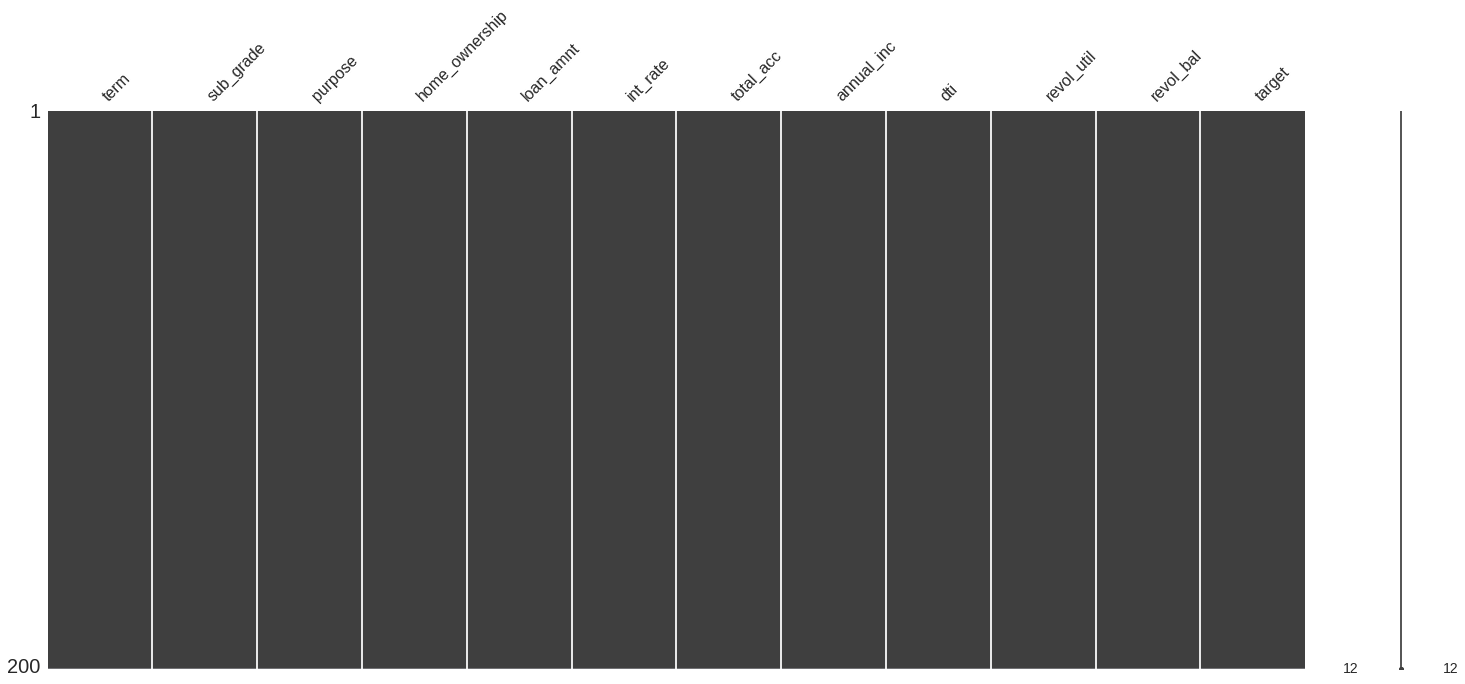

In [70]:
import missingno as msno
msno.matrix(df.sample(200))

# Step 2  Prepare for the model training

In [71]:
a=list(enumerate(sorted(df.sub_grade.unique())))
dictgrade= {x:y+1 for y,x in a }

In [6]:
dictgrade = dict()
beginNum = ord('A')
endNum = ord('G')
count = 0
for number in range(beginNum, endNum+1):
    for num in range(1, 6):
        count += 1
        dictgrade[str(chr(number)) + str(num)] = count
#print(sorted(dictgrade.items()))


In [72]:
#do some mapping for categorical features
df['sub_grade']=df.sub_grade.map(dictgrade)

In [73]:
#create dummy variables (one hot key conversion)

def convert_to_binary(df, column_to_convert):
    categories = list(df[column_to_convert].drop_duplicates())
    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert[:5] + '_' + cat_name[:10]
        df[col_name] = 0
        df.loc[(df[column_to_convert] == category), col_name] = 1

    return df

In [74]:
df=convert_to_binary(df,'term')
df=convert_to_binary(df,'home_ownership')
df=convert_to_binary(df,'purpose')

In [75]:
df=df.drop(['term','purpose','home_ownership'], axis=1)
df.columns

Index(['sub_grade', 'loan_amnt', 'int_rate', 'total_acc', 'annual_inc', 'dti',
       'revol_util', 'revol_bal', 'target', 'term__36_months',
       'term__60_months', 'home__rent', 'home__own', 'home__mortgage',
       'home__other', 'home__none', 'home__any', 'purpo_credit_car',
       'purpo_car', 'purpo_small_busi', 'purpo_other', 'purpo_wedding',
       'purpo_debt_conso', 'purpo_home_impro', 'purpo_major_purc',
       'purpo_medical', 'purpo_moving', 'purpo_vacation', 'purpo_house',
       'purpo_renewable_', 'purpo_educationa'],
      dtype='object')

In [76]:
rt=df.drop(['target'],axis=1)

# Vectorized some categorical fields, and scaled every field to 0-1 range.

In [ ]:
from sklearn.cross_validation import train_test_split
min_max_scaler = preprocessing.MinMaxScaler()
rt= min_max_scaler.fit_transform(rt)
loan_train, loan_test, target_train, target_test = train_test_split(rt, df.target.as_matrix())
print ('Training set: ', len(loan_train), len(target_train))
print ('Test set: ', len(loan_test), len(target_test))

# Step3 Start training

In [97]:
def perfmetrics(model, test, target):
    pred = model.predict(test)
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(0, len(test)):
        if 0.9 < pred[i] < 1.1:
            if 0.9 < target[i] < 1.1:
                TP += 1
            else:
                FP += 1
        else:
            if -0.1 < target[i] < 0.1:
                TN += 1
            else:
                FN += 1
    return (TP, TN, FP, FN)

In [298]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, n_estimators=11, max_features=5)

truedefault = 0
for i in range(0, len(target_train)):
    if  0.9 < target_train[i] < 1.1:
        truedefault += 1

weight = float((len(target_train) - truedefault)) / float(truedefault)

print ('the weight is', weight)

weightarray = []

for i in range(0, len(target_train)):
    if 0.9 < target_train[i] and target_train[i] < 1.1:
        #weightarray.append(10)
        weightarray.append(weight)
    else:
        weightarray.append(1)

weightarr = np.array(weightarray)

rf.fit(loan_train, target_train)

TP, TN, FP, FN = perfmetrics(rf, loan_test, target_test)

print ('True Positive', TP)
print ('False Positive', FP)
print ('True Negative', TN)
print ('False Negative', FN)

ct=pd.DataFrame({"Predicted Negative":[TN, FN],"Predicted Positive":[FP, TP]}, index=['Actual Negative','Actual Positive'])
ct

the weight is 1.0129946510821652
True Positive 29844
False Positive 20756
True Negative 33788
False Negative 23997


,Predicted Negative,Predicted Positive
Actual Negative,33788,20756
Actual Positive,23997,29844


In [136]:
l=list(df.columns)
del l[8]

In [138]:
import copy
import csv

featim = copy.copy(rf.feature_importances_)
features = []
features=l
        
importances = []
for i in range(0, len(features)):
    featob = {}
    featob['feature'] = features[i]
    featob['importance'] = featim[i]
    importances.append(featob)
# sort the feature importance
sort = False
while not sort:
    sort = True
    for elem in range(0, len(features)-1):
        if importances[elem]['importance'] > importances[elem+1]['importance']:
            sort = False
            tmp = importances[elem+1]
            importances[elem+1] = importances[elem]
            importances[elem] = tmp
importances.reverse()

for i in range(0, 10):
    print ('the ' + str(i+1) + ' most important feature is', importances[i]['feature'], 'with', importances[i]['importance'])




the 1 most important feature is sub_grade with 0.362837970224
the 2 most important feature is int_rate with 0.195708709335
the 3 most important feature is term__36_months with 0.183399846416
the 4 most important feature is dti with 0.070634017171
the 5 most important feature is annual_inc with 0.0518551350593
the 6 most important feature is term__60_months with 0.0435885975994
the 7 most important feature is revol_util with 0.039845607067
the 8 most important feature is home__rent with 0.015991447375
the 9 most important feature is loan_amnt with 0.00930685674518
the 10 most important feature is home__mortgage with 0.00786614085931


In [299]:
# test it
#print ('the accuracy of Random Forest is ', rf.score(loan_test, target_test))
print ('Accuracy: ', (TP+TN)/(TP+TN+FP+FN))
print ('Error rate: ', (FP+FN)/(TP+TN+FP+FN))
print ('Precision: ', (TP)/(TP+FP))
print ('Recall: ', (TP)/(TP+FN))
print ('Sensitivity: ', (TP)/(TP+FP))
print ('Specificity: ', (TN)/(TN+FN))

Accuracy:  0.5870923098214698
Error rate:  0.41290769017853024
Precision:  0.589802371541502
Recall:  0.5542987685964228
Sensitivity:  0.589802371541502
Specificity:  0.584719217790084


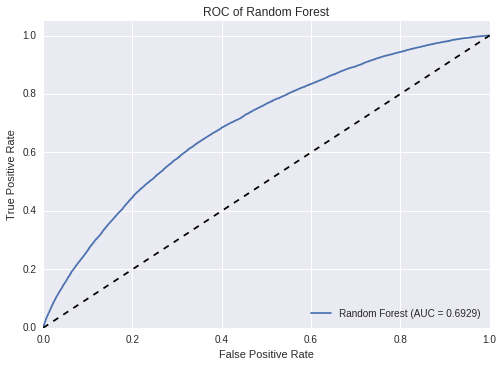

In [146]:
# plot ROC  #
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 2):
    fpr[i], tpr[i], hold1 = roc_curve(target_test, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
plt.plot(fpr[1], tpr[1], label='Random Forest (AUC = {0:0.4f})'.format(roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")


# Try different models

In [147]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(loan_train, target_train, sample_weight=weightarr)

print(clf.score(loan_test, target_test))


0.637773109244


In [301]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators=100)
clf.fit(loan_train, target_train)
print(clf.score(loan_test, target_test))

0.666826590395


In [150]:
import xgboost as xgb
from sklearn.cross_validation import cross_val_score

clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(loan_train, target_train, sample_weight=weightarr)

print(clf.score(loan_test, target_test))

TP, TN, FP, FN = perfmetrics(rf, loan_test, target_test)

print ('True Positive', TP)
print ('False Positive', FP)
print ('True Negative', TN)
print ('False Negative', FN)

ct=pd.DataFrame({"Predicted Negative":[TN, FN],"Predicted Positive":[FP, TP]}, index=['Actual Negative','Actual Positive'])
ct

0.644733893557
True Positive 11333
False Positive 21113
True Negative 33417
False Negative 5537


,Predicted Negative,Predicted Positive
Actual Negative,33417,21113
Actual Positive,5537,11333


# Stack models together 

In [151]:
from sklearn.cross_validation import KFold
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(len(y), n_folds=self.n_folds, shuffle=True, random_state=2016))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                clf.fit(X_train, y_train, sample_weight=weightarr[train_idx])
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]

            S_test[:, i] = S_test_i.mean(1)

        self.stacker.fit(S_train, y, sample_weight=weightarr)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred

In [152]:
clf1 = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf3 = AdaBoostClassifier(n_estimators=100)

stacker=xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

e = Ensemble(5, stacker, [clf1,clf2,clf3])
pred=e.fit_predict(loan_train, target_train, loan_test)

test=loan_test
target=target_test
TP, TN, FP, FN = 0, 0, 0, 0
for i in range(0, len(test)):
    if 0.9 < pred[i] < 1.1:
        if 0.9 < target[i] < 1.1:
            TP += 1
        else:
            FP += 1
    else:
        if -0.1 < target[i] < 0.1:
            TN += 1
        else:
            FN += 1


In [153]:
print ('True Positive', TP)
print ('False Positive', FP)
print ('True Negative', TN)
print ('False Negative', FN)

ct=pd.DataFrame({"Predicted Negative":[TN, FN],"Predicted Positive":[FP, TP]}, index=['Actual Negative','Actual Positive'])
ct

True Positive 11244
False Positive 19724
True Negative 34806
False Negative 5626


,Predicted Negative,Predicted Positive
Actual Negative,34806,19724
Actual Positive,5626,11244


In [155]:
print ('Accuracy: ', (TP+TN)/(TP+TN+FP+FN))

Accuracy:  0.6449579831932774


In [156]:
df.head(2)

,sub_grade,loan_amnt,int_rate,total_acc,annual_inc,dti,revol_util,revol_bal,target,term__36_months,...,purpo_wedding,purpo_debt_conso,purpo_home_impro,purpo_major_purc,purpo_medical,purpo_moving,purpo_vacation,purpo_house,purpo_renewable_,purpo_educationa
0,7,5000.0,10.65,9.0,24000.0,27.65,83.7,13648.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,14,2500.0,15.27,4.0,30000.0,1.00,9.4,1687.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
from sklearn.neighbors import NearestNeighbors
import random
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    #print('n_minority_samples  ', n_minority_samples)
    #print('N ', N)
    print ('n_synthetic_samples  ',n_synthetic_samples)
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        #print('nn  ',nn)
        for n in range(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            
            if (n+i) < n_minority_samples:
                #S[n + i*N, :] = T[i,:] + gap * dif[:]
                S[n + i, :] = T[i,:] + gap * dif[:]
    
    return S

In [236]:
type(tm)

numpy.ndarray

In [260]:
ttt=SMOTE(n2,100,10)

In [261]:
ttt.shape

(73970, 30)

In [257]:
n2=np.concatenate((tm,tt), axis=0)

In [262]:
n3=np.concatenate((n2,ttt), axis=0)
n3.shape

(147940, 30)

In [264]:
n4=np.concatenate((n3,rt), axis=0)
n4.shape

(433540, 30)

In [265]:
t1=df.target.as_matrix()
t1.shape

(285600,)

In [266]:
t0=np.ones(147940)
t0.shape

(147940,)

In [269]:
t4=np.concatenate((t0,t1), axis=0)

In [273]:
pl=pd.DataFrame(n4)
pr=pd.DataFrame(t4)
r4=pd.concat([pl,pr],axis=1)

In [275]:
s4=r4

In [276]:
r4=r4.iloc[np.random.permutation(len(r4))]

In [278]:
np4=r4.as_matrix()
np4.shape

(433540, 31)

In [281]:
loan_train=np4[:,:30]
loan_train.shape

(433540, 30)

In [291]:
target_train=np4[:,30:31]
target_train.shape

(433540, 1)

In [292]:
target_train[:3,]

array([[ 1.],
       [ 0.],
       [ 1.]])

In [295]:
loan_train, loan_test, target_train, target_test = train_test_split(np4[:,:30], np4[:,30:31])
print ('Training set: ', len(loan_train), len(target_train))
print ('Test set: ', len(loan_test), len(target_test))

Training set:  325155 325155
Test set:  108385 108385


In [296]:
clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(loan_train, target_train)

print(clf.score(loan_test, target_test))

TP, TN, FP, FN = perfmetrics(clf, loan_test, target_test)

print ('True Positive', TP)
print ('False Positive', FP)
print ('True Negative', TN)
print ('False Negative', FN)

ct=pd.DataFrame({"Predicted Negative":[TN, FN],"Predicted Positive":[FP, TP]}, index=['Actual Negative','Actual Positive'])
ct

0.720090418416
True Positive 35947
False Positive 12444
True Negative 42100
False Negative 17894


,Predicted Negative,Predicted Positive
Actual Negative,42100,12444
Actual Positive,17894,35947


In [297]:
35947/(35947+17894)

0.6676510466001746

In [3]:
from collections import Counter
Counter(list(df.loan_status)).most_common()

NameError: name 'df' is not defined

In [1]:
import missingno as msno

NameError: name 'df' is not defined